# Sudoku solver
We would like to be able to take an image of an sudoku grid, extract the numbers that have been filled in, solve the puzzle, then project the solution back into the image.

In [2]:
from skimage.filters import threshold_local
import numpy as np
import cv2
import imutils
from imutils import contours
%matplotlib inline

# 0. Load image
We will assume that all input images will have just one grid, where the grid is the largest rectangular shape in the image.

Original shape = 423 x 419
Resized to 500 x 495


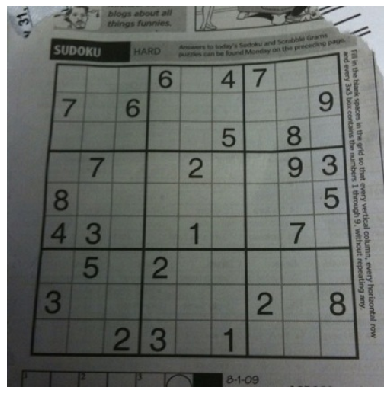

In [3]:
import matplotlib.pyplot as plt
# default figure size
plt.rcParams['figure.figsize'] = [7, 7]

# helper function for plotting OpenCV images without
# needing to convert to RGB every time
def imshow(im, title=None, axis=True):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(title)
    if not axis:
        plt.axis('off')
    plt.show()

image = cv2.imread('sudoku2.jpg')
print(f'Original shape = {image.shape[0]} x {image.shape[1]}')
ratio = image.shape[0] / 500.0
orig = image.copy()
image = imutils.resize(image, height=500)
print(f'Resized to {image.shape[0]} x {image.shape[1]}')

imshow(image, axis=False)

---
## 1. Find Sudoku puzzle in image
### 1.1. Pre-processing
  - 1. Grayscale
  - 2. Gaussian blur
  - 3. Adaptive threshold

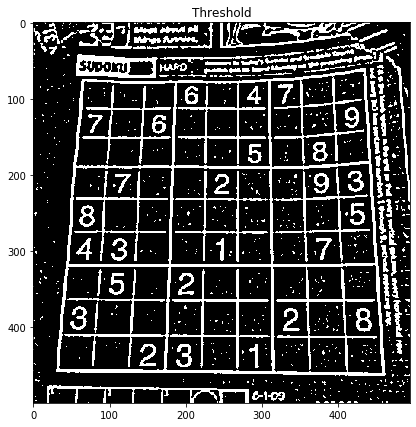

In [4]:
# 1. grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# 2. blur
gray = cv2.GaussianBlur(gray, (5, 5), 0)
# 3. threshold
thresh = cv2.adaptiveThreshold(gray, 255, 1, 1, 11, 2)

# show the original image and the edge detected image
imshow(thresh, 'Threshold')

### 1.2. Find contours
  - 1. Find all contours
  - 2. Keep only the largest ones (assuming the photo has Sudoku as its main subject)

In [5]:
# find the contours in the thresholded image
cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print(f'{len(cnts)} contours found')

# keep only the largest ones
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]
print('Shapes of 5 largest:', [i.shape for i in cnts])

1028 contours found
Shapes of 5 largest: [(221, 1, 2), (81, 1, 2), (75, 1, 2), (59, 1, 2), (84, 1, 2)]


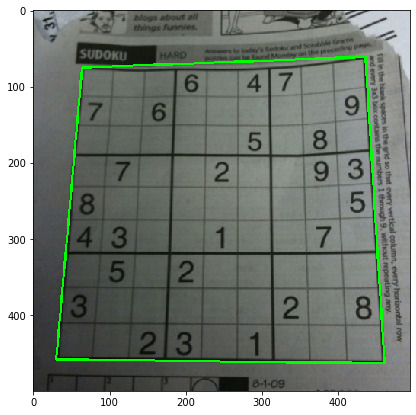

[[[436  61]]

 [[ 64  75]]

 [[ 30 458]]

 [[461 463]]]


In [6]:
# loop over the contours, started with the biggest one
for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)

    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    if len(approx) == 4:
        screenCnt = approx
        break

imshow(cv2.drawContours(image.copy(), [screenCnt], -1, (0, 255, 0), 2))

print(screenCnt)

## 3. Apply perspective transform
The result from the code above is four points, representing the four corners of the Sudoku grid. The next step is to extract only this region of the image as a square.

The order of the four points given above is not guaranteed to be the same for different images. So we will create a function that takes four points, in any order, and returns them in a fixed order each time. Then, we will use this function to extract only this region of the original image.

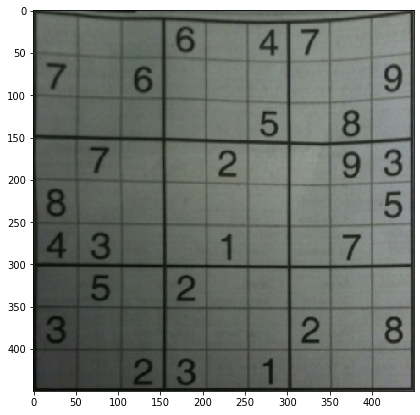

In [6]:
def order_points(pts):
    pts = pts.reshape((4,2))
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype='float32')

    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    # return the ordered coordinates
    return rect


def four_point_transform(image, pts, size=450):
    # obtain a consistent order of the points and unpack them
    # individually
    rect = order_points(pts)
    tl, tr, br, bl = rect
    
    new_pts = np.array(
        [
            [0,0],  # top left
            [size-1,0],  # top right
            [size-1,size-1],  # bottom right
            [0,size]  # bottom left
        ], np.float32)

    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, new_pts)
    warped = cv2.warpPerspective(image, M, (size, size))

    # return the warped image
    return warped

image = four_point_transform(image, screenCnt)
imshow(image)

## 4. Binary image

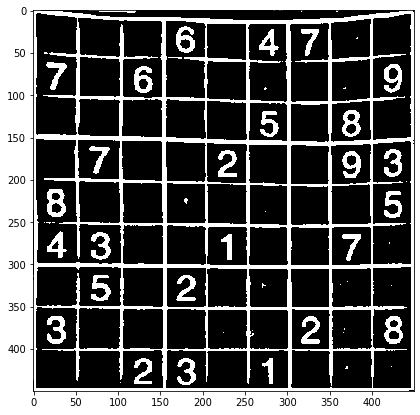

In [7]:
# Load image, grayscale, and adaptive threshold
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,57,5)
imshow(thresh)

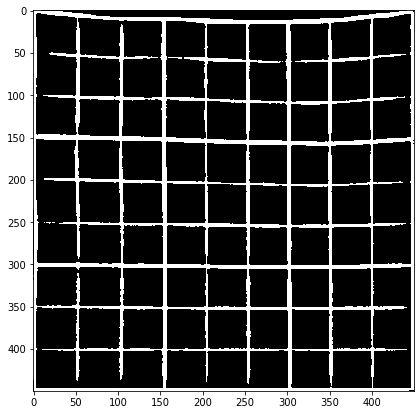

In [8]:
# Filter out all numbers and noise to isolate only boxes
cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 1000:
        cv2.drawContours(thresh, [c], -1, (0,0,0), -1)
        
imshow(thresh)

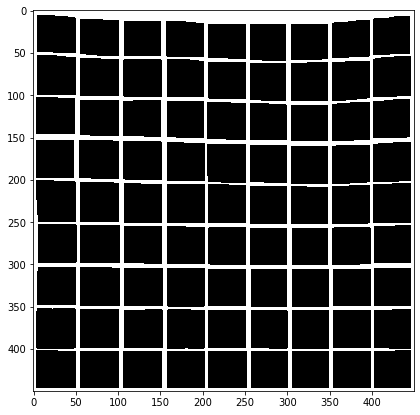

In [9]:
# Fix horizontal and vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, vertical_kernel, iterations=9)
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,1))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, horizontal_kernel, iterations=4)
imshow(thresh)

In [10]:
# Sort by top to bottom and each row by left to right
invert = 255 - thresh
cnts = cv2.findContours(invert, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts, _ = contours.sort_contours(cnts, method='top-to-bottom')

sudoku_rows = []
row = []
for i, c in enumerate(cnts, 1):
    area = cv2.contourArea(c)
    if area < 50000:
        row.append(c)
        if i % 9 == 0:  
            (cnts, _) = contours.sort_contours(row, method='left-to-right')
            sudoku_rows.append(cnts)
            row = []

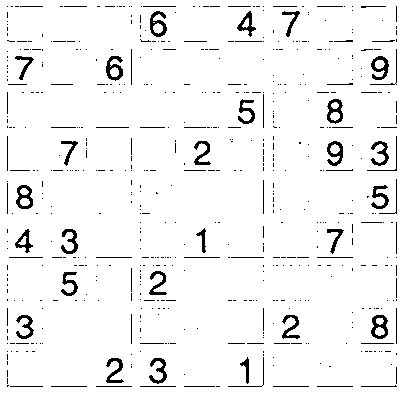

In [11]:
def get_cell(img, tol=0):
    # img is 2D image data
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # tol  is tolerance
    # Mask of non-black pixels (assuming image has a single channel).
    mask = img>tol

    # Coordinates of non-black pixels.
    coords = np.argwhere(mask)

    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top

    # Get the contents of the bounding box.
    cropped = image[x0:x1, y0:y1]
    resized = cv2.resize(cropped, (72, 72))
    blur = cv2.medianBlur(resized, 7)
    thresh = cv2.adaptiveThreshold(cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
#     thresh = cv2.adaptiveThreshold(cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY), 255, 1, 1, 11, 2)
    return thresh

grid = []

# Iterate through each box
for row in sudoku_rows:
    grid_row = []
    for c in row:
        mask = np.zeros(image.shape, dtype=np.uint8)
        cv2.drawContours(mask, [c], -1, (255,255,255), -1)
        result = cv2.bitwise_and(image, mask)
        result = get_cell(result)
        grid_row.append(result)
    grid.append(grid_row)
    
grid = np.array(grid)
grid.shape

fig, axs = plt.subplots(9,9)

for i in range(9):
    for j in range(9):
        axs[i,j].imshow(cv2.cvtColor(grid[i,j], cv2.COLOR_BGR2RGB))
        axs[i,j].axis('off')

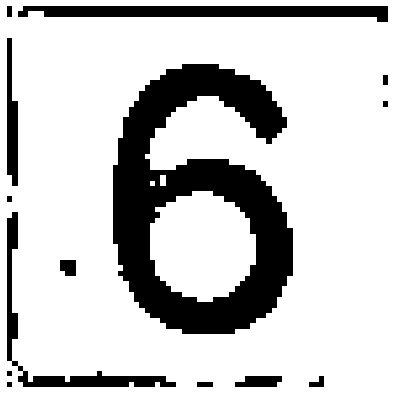

In [12]:
# show item in row 1, col 4
imshow(grid[0,3], axis=False)